Loding Packages

In [1]:
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np


Importing Dataset:

In [2]:
anime_info_df= pd.read_csv('./anime.csv')
user_rating_df= pd.read_csv('./rating.csv')


In [3]:
anime_info_df.info()
print("\n")
user_rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


Hmm, in anime_info_df why is episodes column data type of object it should be int/float. As the column suggets the number of episodes in that anime. This may be case when there are values with more than one data type we need to take a closer look what mischief does this column contains. 

In data frame user_rating_df rating column is of data type int. Although ratings are give in scale of 0 to 10. Let's change it to float as time may come when we need to aggregate this column. 
Let's change the column name of rating to user_rating to avoid confusion if we merget these two dataframe


In [4]:
print("Number of unique values in episodes columns:", anime_info_df["episodes"].nunique())
anime_info_df["episodes"].unique()

Number of unique values in episodes columns: 187


array(['1', '64', '51', '24', '10', '148', '110', '13', '201', '25', '22',
       '75', '4', '26', '12', '27', '43', '74', '37', '2', '11', '99',
       'Unknown', '39', '101', '47', '50', '62', '33', '112', '23', '3',
       '94', '6', '8', '14', '7', '40', '15', '203', '77', '291', '120',
       '102', '96', '38', '79', '175', '103', '70', '153', '45', '5',
       '21', '63', '52', '28', '145', '36', '69', '60', '178', '114',
       '35', '61', '34', '109', '20', '9', '49', '366', '97', '48', '78',
       '358', '155', '104', '113', '54', '167', '161', '42', '142', '31',
       '373', '220', '46', '195', '17', '1787', '73', '147', '127', '16',
       '19', '98', '150', '76', '53', '124', '29', '115', '224', '44',
       '58', '93', '154', '92', '67', '172', '86', '30', '276', '59',
       '72', '330', '41', '105', '128', '137', '56', '55', '65', '243',
       '193', '18', '191', '180', '91', '192', '66', '182', '32', '164',
       '100', '296', '694', '95', '68', '117', '151', '130',

Oh! I see why episode dataframe is of datatype object. Unknown is the culprit here. Luckily I found just the right function to change Unknown to NAN and other number as string to float.

In [5]:
anime_info_df["episodes"]=pd.to_numeric(anime_info_df["episodes"],errors='coerce')
print("Number of unique values in episodes columns:", anime_info_df["episodes"].nunique())
print("Data type of episode column:",anime_info_df["episodes"].dtype)

Number of unique values in episodes columns: 186
Data type of episode column: float64


Now let's rename rating column to user_rating so that it is easier to merger later on

In [6]:
user_rating_df.rename(columns={"rating":"user_rating"},inplace=True)
user_rating_df["user_rating"]=user_rating_df["user_rating"].astype(float)

# Duplicates

Let's check if there are any duplicate rows in our dataframes

In [7]:
print(f"Number of duplicate rows in user_rating_df : {user_rating_df.duplicated().sum()}")
print(f"Number of duplicate rows in anime_info_df : {anime_info_df.duplicated().sum()}")

Number of duplicate rows in user_rating_df : 1
Number of duplicate rows in anime_info_df : 0


Looks like there is one duplicate row in user_rating_df

Well it doesn't hurt to make sure if there are duplicate animes with different features. So Let's see if there are duplicate anime_id in anime_info_df

In [8]:
print(f"Number of duplicate anime_ids: {anime_info_df.duplicated(subset=['anime_id']).sum()}")

Number of duplicate anime_ids: 0


phew, that's a good start

Now Just to be sure let's check if a user gave rating to same anime multiple times.

In [9]:
duplicate_df=user_rating_df[user_rating_df.duplicated(subset=['user_id', 'anime_id'], keep=False)].sort_values("anime_id")
duplicate_df

,user_id,anime_id,user_rating
4499243,42653,1575,8.0
4499286,42653,1575,6.0
4499244,42653,2001,8.0
4499288,42653,2001,10.0
4499255,42653,11757,8.0
4499307,42653,11757,5.0
4499258,42653,16498,8.0
4499316,42653,16498,8.0
4499261,42653,20507,7.0
4499320,42653,20507,9.0


Now it think it was a good thing to check. Looks like **User 42653** had change of hearts.

In [10]:
mean_duplicate_df=duplicate_df.groupby(["user_id","anime_id"]).mean().reset_index()
mean_duplicate_df

,user_id,anime_id,user_rating
0,42653,1575,7.0
1,42653,2001,9.0
2,42653,11757,6.5
3,42653,16498,8.0
4,42653,20507,8.0
5,42653,22319,7.0
6,42653,23283,8.5


Now we have the mean of duplicate ratings by users. Lets concatinate this mean_duplicate_df dataframe and drop the duplicates keeping the last values

In [11]:
user_rating_df=pd.concat([user_rating_df,mean_duplicate_df],ignore_index=True)

In [12]:
user_rating_df.drop_duplicates(subset=["user_id","anime_id"], keep="last", inplace=True,ignore_index=True)

In [13]:
ids_to_check=[1575,2001,11757,20507,22319,23283]
for i in ids_to_check:
    print(user_rating_df[(user_rating_df["user_id"] == 42653) & (user_rating_df["anime_id"]==i )])
    print("\n")

         user_id  anime_id  user_rating
7813723    42653      1575          7.0


         user_id  anime_id  user_rating
7813724    42653      2001          9.0


         user_id  anime_id  user_rating
7813725    42653     11757          6.5


         user_id  anime_id  user_rating
7813727    42653     20507          8.0


         user_id  anime_id  user_rating
7813728    42653     22319          7.0


         user_id  anime_id  user_rating
7813729    42653     23283          8.5




Looks like it did the job.

# NULL VALUES

Let's handle the null values.

First in our dataset user who didn't gave any rantings are denoted by -1 . Lets change it nan

In [14]:
#changing -1 to nan
user_rating_df["user_rating"].replace(to_replace=-1, value=np.nan, inplace=True)

In [15]:
print(f"Null values in user_rating_df : \n \n{user_rating_df.isna().sum()}")
print("\n")
print(f"Null values in anime_info_df : \n \n{anime_info_df.isna().sum()}")

Null values in user_rating_df : 
 
user_id              0
anime_id             0
user_rating    1476496
dtype: int64


Null values in anime_info_df : 
 
anime_id      0
name          0
genre        62
type         25
episodes    340
rating      230
members       0
dtype: int64


Let's look at the number of rows with null vaues

In [16]:
print(f"There are {anime_info_df.isna().any(axis=1).sum()} rows with null vaues in anime_info_df.")

There are 464 rows with null vaues in anime_info_df.


### Merging dataframe
Well we need to merge two dataframes anime_info_df and user_rating_df so, first let's Merge two dataframe to get anime_df dataframe and then handle the null and missing values. It may be possible that null values may reduce while joining. Some anime with null rows from aime_info_df may not be in user_rating_df.

In [17]:
anime_df=pd.merge(anime_info_df,user_rating_df, on="anime_id")
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7813720 entries, 0 to 7813719
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   anime_id     int64  
 1   name         object 
 2   genre        object 
 3   type         object 
 4   episodes     float64
 5   rating       float64
 6   members      int64  
 7   user_id      int64  
 8   user_rating  float64
dtypes: float64(3), int64(3), object(3)
memory usage: 596.1+ MB


Since we did the inner merge (default parameter) the number of null values will differ from anime_info_df. Now let's look at the distribution of null values in anime_df dataframe

In [18]:
print(f"Null values in anime_df : \n \n{anime_df.isna().sum()}")
print("\n")
print(f"Number of duplicate rows in anime_df dataset: {anime_df.duplicated().sum()}")

Null values in anime_df : 
 
anime_id             0
name                 0
genre              110
type                 4
episodes             8
rating               6
members              0
user_id              0
user_rating    1476488
dtype: int64


Number of duplicate rows in anime_df dataset: 0


In [19]:
print(f"There are {anime_df.isna().any(axis=1).sum()} rows with null vaues in anime_df.")

There are 1476583 rows with null vaues in anime_df.


Lets add a new column ratings_count to see whats the distribution of ratings count for each anime.

First let's create a dataframe with just anime_id and rating_count and then merge it to anime_df

In [20]:
num_ratings= anime_df.groupby("anime_id")["user_rating"].count().reset_index()
num_ratings.rename(columns={"user_rating":"rating_counts"}, inplace=True)
num_ratings.head()

,anime_id,rating_counts
0,1,13449
1,5,5790
2,6,9385
3,7,2169
4,8,308


In [21]:
anime_df= pd.merge(anime_df,num_ratings, on="anime_id")
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members,user_id,user_rating,rating_counts
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,99,5.0,1961
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,152,10.0,1961
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,244,10.0,1961
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,271,10.0,1961
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,278,NaN,1961


In [22]:
anime_df[anime_df["rating_counts"].gt(500)]["anime_id"].unique().shape

(2225,)

In [23]:
null_anime_df= anime_df.isna()
null_anime_df.head()

,anime_id,name,genre,type,episodes,rating,members,user_id,user_rating,rating_counts
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,True,False


In [24]:
row_null=pd.DataFrame(null_anime_df.sum(axis=1).value_counts()).reset_index()
row_null.rename(columns={"index":"null_count",0:'rows'}, inplace=True)
row_null

,null_count,rows
0,0,6337137
1,1,1476554
2,2,25
3,3,4


Looks like there are 4 rows with 3 null values in them

In [25]:
# total number of column - threshold
#threshold= 2 # threshhold is acceptable number of null values
#anime_df.dropna(thresh= anime_df.shape[1]-threshold, inplace=True) # in pandas thresh expect value to be number of non null values to have in a row


In this case you can do simply .dropna to remove na rows alltogether but i am gonna keep  above cell just as remainder 😅

In [26]:
# anime_df.dropna(inplace=True)
# anime_df.isna().sum(axis=1).value_counts()

Let's create a new dataframe where user_ratings are aggregated by mean.

In [27]:
df=anime_df.dropna()
print(df["anime_id"].nunique())
df=df.loc[:, df.columns != "user_id"].groupby(["anime_id", "name","type","genre","episodes"]).mean().reset_index().round(2).sort_values("user_rating")
df.shape

9890


(9890, 9)

In [28]:
df.isna().sum()

anime_id         0
name             0
type             0
genre            0
episodes         0
rating           0
members          0
user_rating      0
rating_counts    0
dtype: int64

In [29]:
df.describe()

,anime_id,episodes,rating,members,user_rating,rating_counts
count,9890.000000,9890.000000,9890.000000,9.890000e+03,9890.000000,9890.000000
mean,11405.737108,12.580384,6.592642,2.190235e+04,6.646399,640.762083
std,10453.397171,48.542434,0.961575,5.988086e+04,1.288945,1798.793168
min,1.000000,1.000000,2.000000,3.300000e+01,1.000000,1.000000
25%,2697.250000,1.000000,6.060000,5.932500e+02,6.080000,9.000000
50%,7489.500000,2.000000,6.670000,2.550500e+03,6.900000,57.000000
75%,18830.500000,12.000000,7.260000,1.392025e+04,7.490000,398.750000
max,34475.000000,1818.000000,9.370000,1.013917e+06,10.000000,34226.000000


Let's set some settings for matplotlib

In [30]:
#Some settings for matplotlib
background_color= '#f6f5f5'
facecolor='#D8D8D8'
grid_color='#EEEEEE'
# chart_colors=["#ffa600","#ff7c43","#f95d6a","#d45087","#a05195","#665191","#2f4b7c","#003f5c"]
chart_colors = [
    "#1f78b4",  # Blue
    "#33a02c",  # Green
    "#e31a1c",  # Red
    "#ff7f00",  # Orange
    "#6a3d9a",  # Purple
    "#b15928",  # Brown
    "#a6cee3",  # Light Blue
    "#b2df8a",  # Light Green
    "#fb9a99",  # Light Red
    "#fdbf6f",  # Light Orange
    "#cab2d6",  # Light Purple
    "#fddaec",  # Light Pink
]


plot_params = {
    'figure.dpi':400,
    'figure.facecolor':background_color,
    'axes.facecolor':background_color ,
    'legend.facecolor':facecolor,
    'figure.facecolor':background_color,
    'legend.edgecolor':background_color,
    'legend.fontsize':3,
    "patch.facecolor": "none",
    "patch.linewidth":0.3,
    'grid.color':grid_color,
    'grid.linewidth':0.4,
    'axes.spines.top':False,
    'axes.spines.right':False,
    'xtick.labelsize': 3,
    'ytick.labelsize': 3,
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
    'xtick.major.size': 1.5,
    'ytick.major.size': 1.5,
    'font.size':3,
}

plt.rcParams.update(plot_params)

In [31]:
exclude_colors = ["#b15928", "#6a3d9a"]
exclude_colors= [color for color  in chart_colors if color not in exclude_colors]
exclude_colors

['#1f78b4',
 '#33a02c',
 '#e31a1c',
 '#ff7f00',
 '#a6cee3',
 '#b2df8a',
 '#fb9a99',
 '#fdbf6f',
 '#cab2d6',
 '#fddaec']

In [32]:
anime_type_df= anime_df.groupby(["anime_id"])["type"].unique().apply(lambda x: x[0]).value_counts().reset_index()
anime_type_df.rename(columns={"index":"type", "type":"count"}, inplace=True)
anime_type_df['label']= anime_type_df['type']+' \n \n'+ anime_type_df['count'].astype(int).astype(str)
anime_type_df


,type,count,label
0,TV,3402,TV \n \n3402
1,OVA,3090,OVA \n \n3090
2,Movie,2142,Movie \n \n2142
3,Special,1582,Special \n \n1582
4,ONA,529,ONA \n \n529
5,Music,451,Music \n \n451


In [33]:
anime_type_df

,type,count,label
0,TV,3402,TV \n \n3402
1,OVA,3090,OVA \n \n3090
2,Movie,2142,Movie \n \n2142
3,Special,1582,Special \n \n1582
4,ONA,529,ONA \n \n529
5,Music,451,Music \n \n451


In [34]:
import squarify

In [35]:
plt.legend?

Signature: plt.legend(*args, **kwargs)
Docstring:
Place a legend on the Axes.

Call signatures::

    legend()
    legend(handles, labels)
    legend(handles=handles)
    legend(labels)

The call signatures correspond to the following different ways to use
this method:

**1. Automatic detection of elements to be shown in the legend**

The elements to be added to the legend are automatically determined,
when you do not pass in any extra arguments.

In this case, the labels are taken from the artist. You can specify
them either at artist creation or by calling the
:meth:`~.Artist.set_label` method on the artist::

    ax.plot([1, 2, 3], label='Inline label')
    ax.legend()

or::

    line, = ax.plot([1, 2, 3])
    line.set_label('Label via method')
    ax.legend()

.. note::
    Specific artists can be excluded from the automatic legend element
    selection by using a label starting with an underscore, "_".
    A string starting with an underscore is the default label for all
    artis

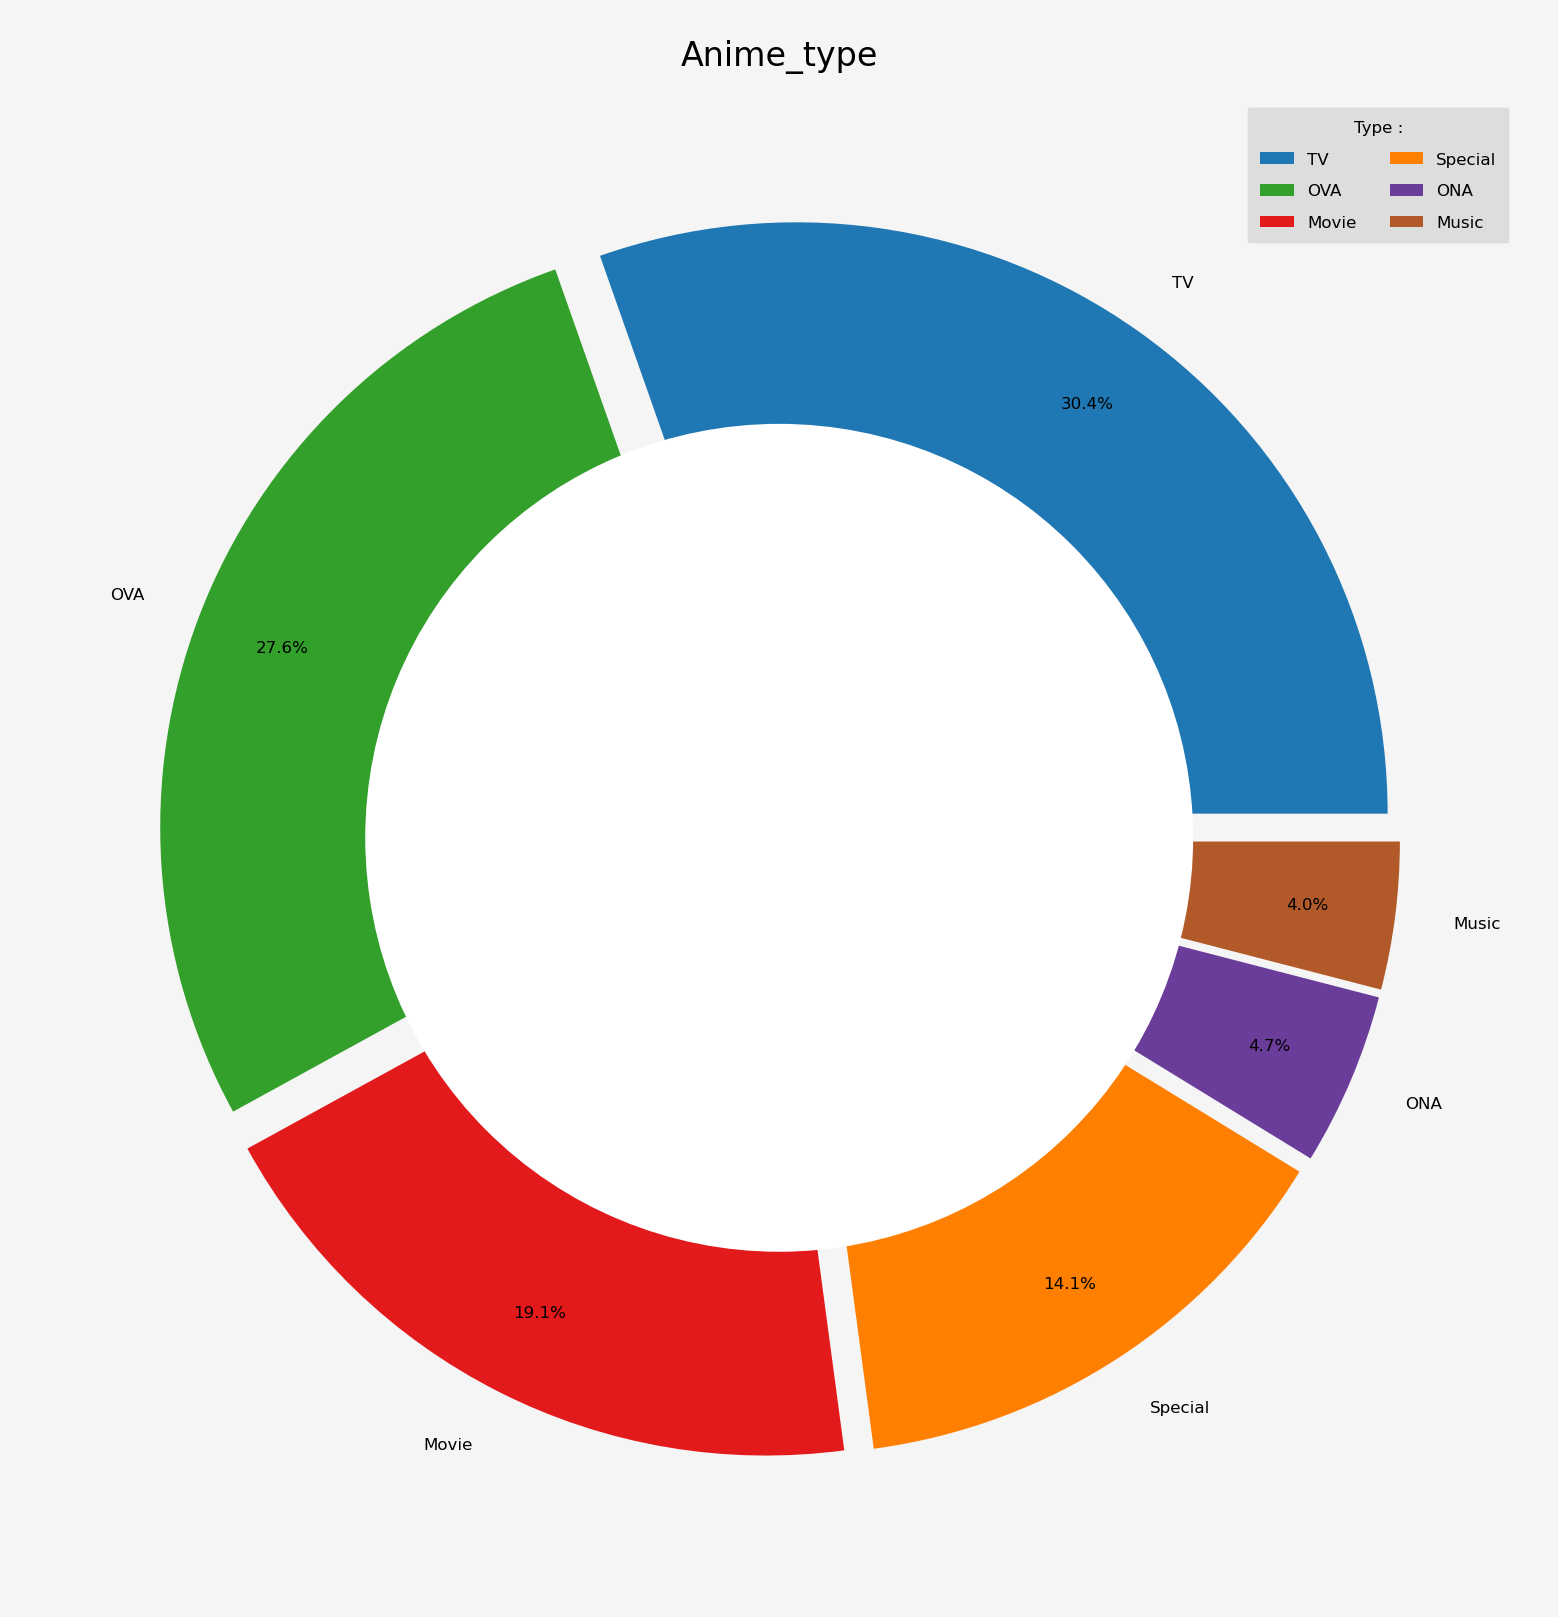

In [36]:
fig=plt.figure()
gs= fig.add_gridspec(1,wspace=0, hspace=0.05)
ax0= fig.add_subplot(gs[0,0])
explode = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05)
ax0_plt= plt.pie(anime_type_df["count"], colors=chart_colors,labels=anime_type_df["type"],autopct='%1.1f%%', pctdistance=0.85, explode=explode)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
ax0.legend(title="Type :",ncols=2, borderpad=0.8,markerscale=0.5, labelspacing=1, loc='upper right' )
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)

plt.title("Anime_type" ,fontsize=6)
plt.show()

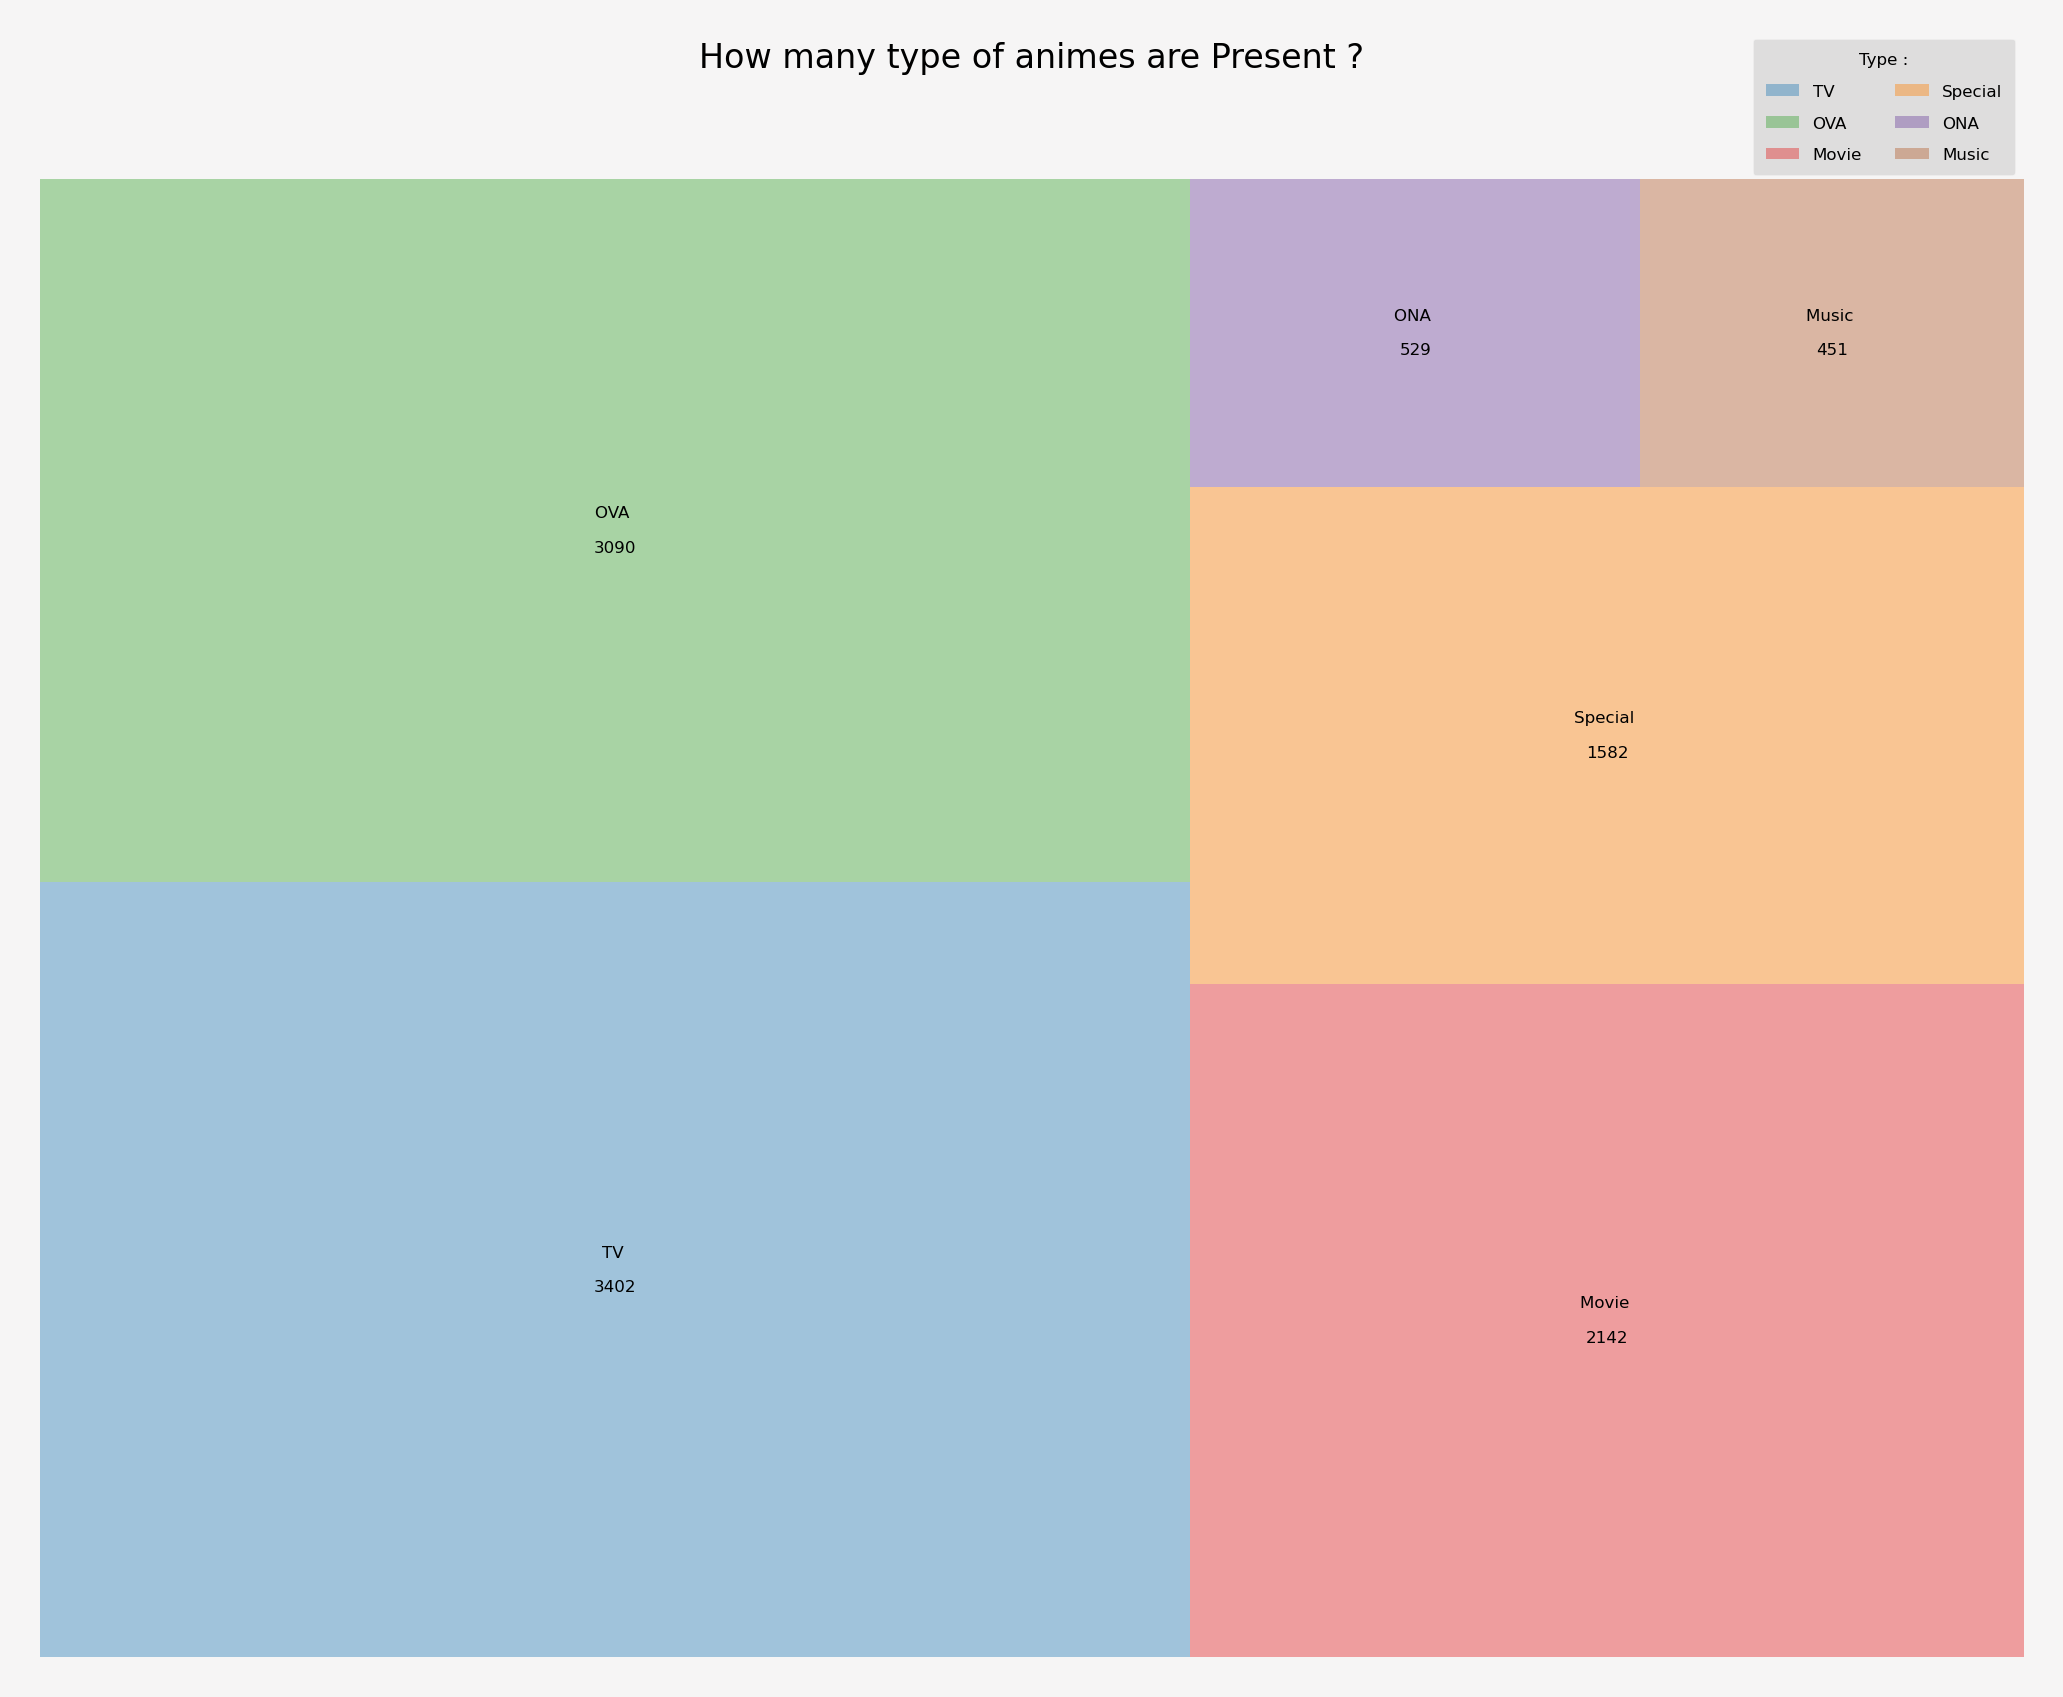

In [37]:
fig=plt.figure()
gs= fig.add_gridspec(1,wspace=0, hspace=0.05)
ax0= fig.add_subplot(gs[0,0])
ax0_plt=squarify.plot(sizes=anime_type_df["count"], label=anime_type_df["label"], color=chart_colors, alpha=.4 )
ax0.legend(anime_type_df["type"],title="Type :",ncols=2, borderpad=0.8,markerscale=0.5, labelspacing=1,bbox_to_anchor=(1, 1.1), loc='upper right' )
plt.title("How many type of animes are Present ?" ,fontsize=6, pad=20)
plt.axis("off")
plt.show()

In [38]:
members_df= anime_df.groupby(["anime_id","name"])["members"].unique().apply(lambda x: x[0]).reset_index().sort_values("members", ascending=False).head(10)
members_df

,anime_id,name,members
1389,1535,Death Note,1013917
7439,16498,Shingeki no Kyojin,896229
6606,11757,Sword Art Online,893100
3965,5114,Fullmetal Alchemist: Brotherhood,793665
4630,6547,Angel Beats!,717796
1427,1575,Code Geass: Hangyaku no Lelouch,715151
10,20,Naruto,683297
5673,9253,Steins;Gate,673572
6288,10620,Mirai Nikki (TV),657190
3558,4224,Toradora!,633817


C:\Users\sanka\AppData\Local\Temp\ipykernel_7832\1441196706.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_xticklabels(members_df["name"], rotation=90,ha="right", rotation_mode="anchor")


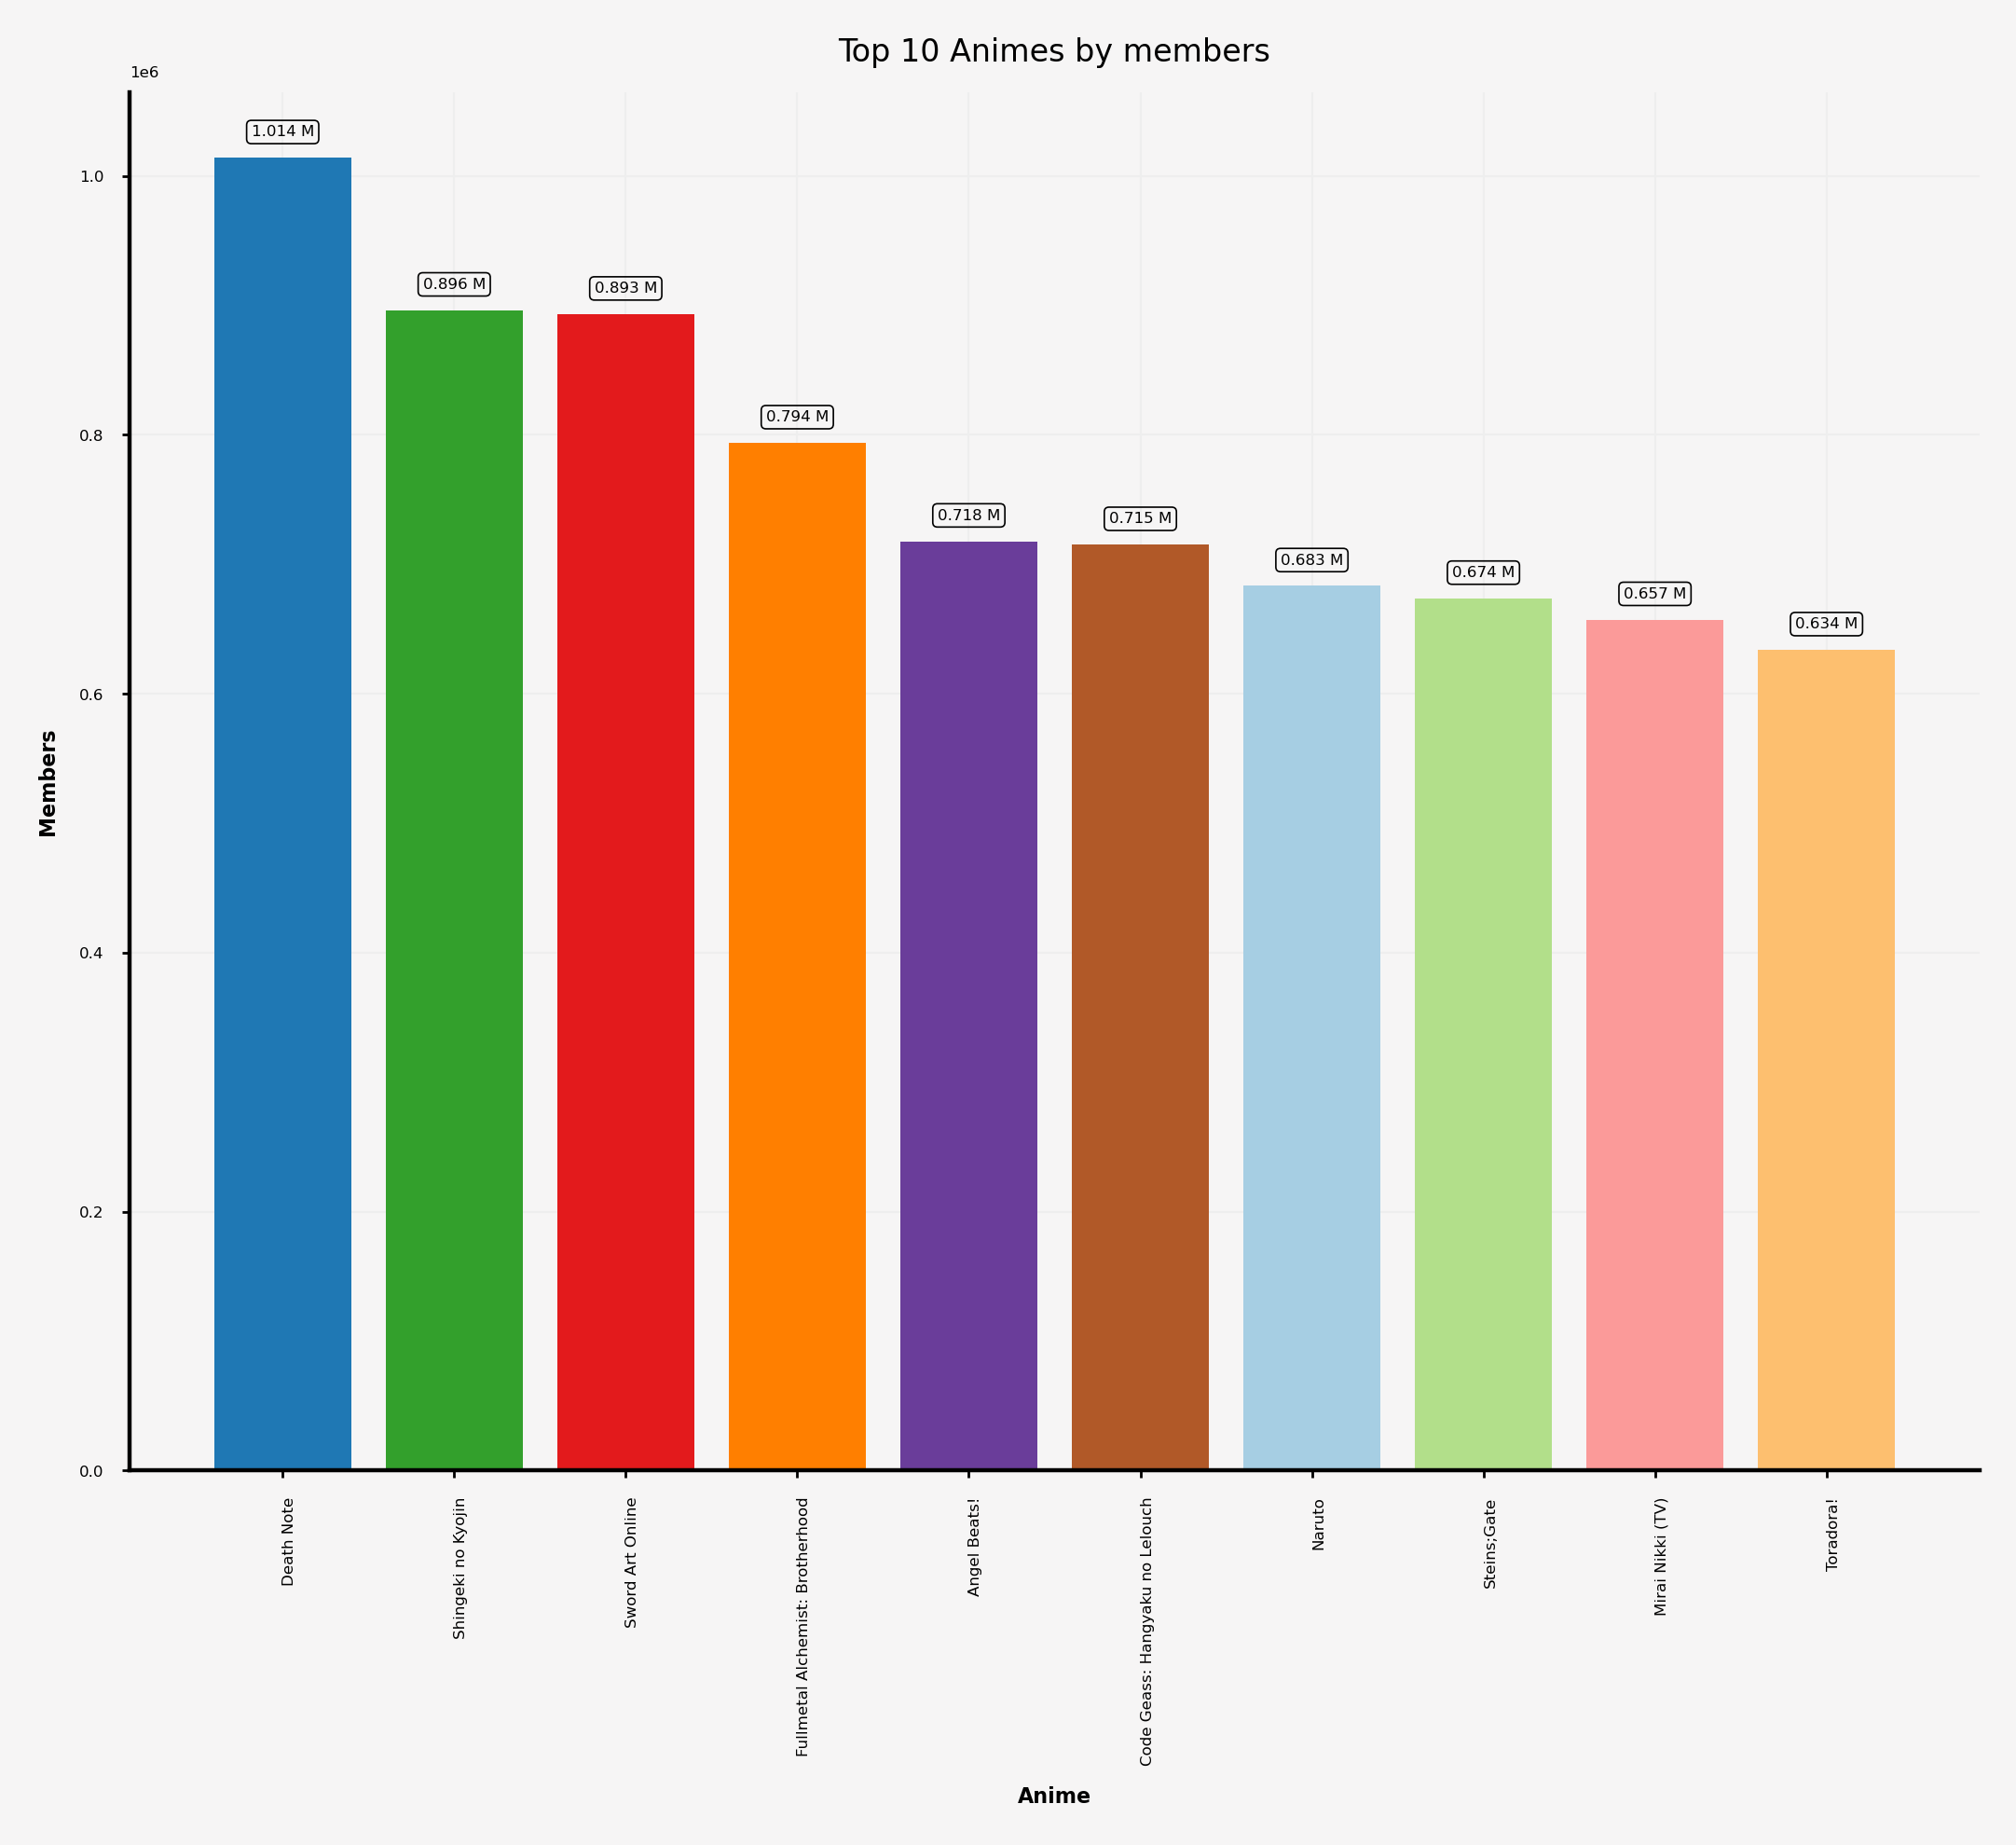

In [39]:
fig=plt.figure()
gs= fig.add_gridspec(1,wspace=0, hspace=0.05)
ax0= fig.add_subplot(gs[0,0])
ax0_plt= ax0.bar(x=members_df["name"], height= members_df["members"], zorder=2,  color=chart_colors)
plt.title("Top 10 Animes by members", fontsize=6)
ax0.set_xticklabels(members_df["name"], rotation=90,ha="right", rotation_mode="anchor")
ax0.set_xlabel('Anime',fontsize=4, weight='bold',)
ax0.set_ylabel('Members',fontsize=4, weight='bold')
ax0.grid(which='major', zorder=0, axis='x')
ax0.grid(which='major', zorder=0, axis='y')
for p in ax0_plt.patches:
    height= p.get_height()
    width= p.get_width()
    if height == 0:
        pass
    else:
        #find x and y coordinate of ear bar to add labels
        x= p.get_center()[0]
        y= height + 20000
        label_value= f'{round(height*0.000001,3)}' + " M"
        ax0.text(x,y,label_value, ha='center', va="center", bbox= dict(boxstyle='round'))
plt.show()

In [40]:
episode_df= anime_df.groupby(["anime_id","name"])["episodes"].unique().apply(lambda x:x[0]).reset_index().sort_values("episodes",ascending=False).head(10)
episode_df

,anime_id,name,episodes
6736,12393,Oyako Club,1818.0
2261,2471,Doraemon (1979),1787.0
8888,23349,Kirin Monoshiri Yakata,1565.0
4530,6277,Manga Nippon Mukashibanashi (1976),1471.0
5275,8213,Hoka Hoka Kazoku,1428.0
8609,22221,Monoshiri Daigaku: Ashita no Calendar,1274.0
6117,10241,Sekai Monoshiri Ryoko,1006.0
8217,20117,Kotowaza House,773.0
5885,9768,Shima Shima Tora no Shimajirou,726.0
3885,4936,Ninja Hattori-kun,694.0


C:\Users\sanka\AppData\Local\Temp\ipykernel_7832\3499735283.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_xticklabels(episode_df["name"], rotation=90,ha="right", rotation_mode="anchor")


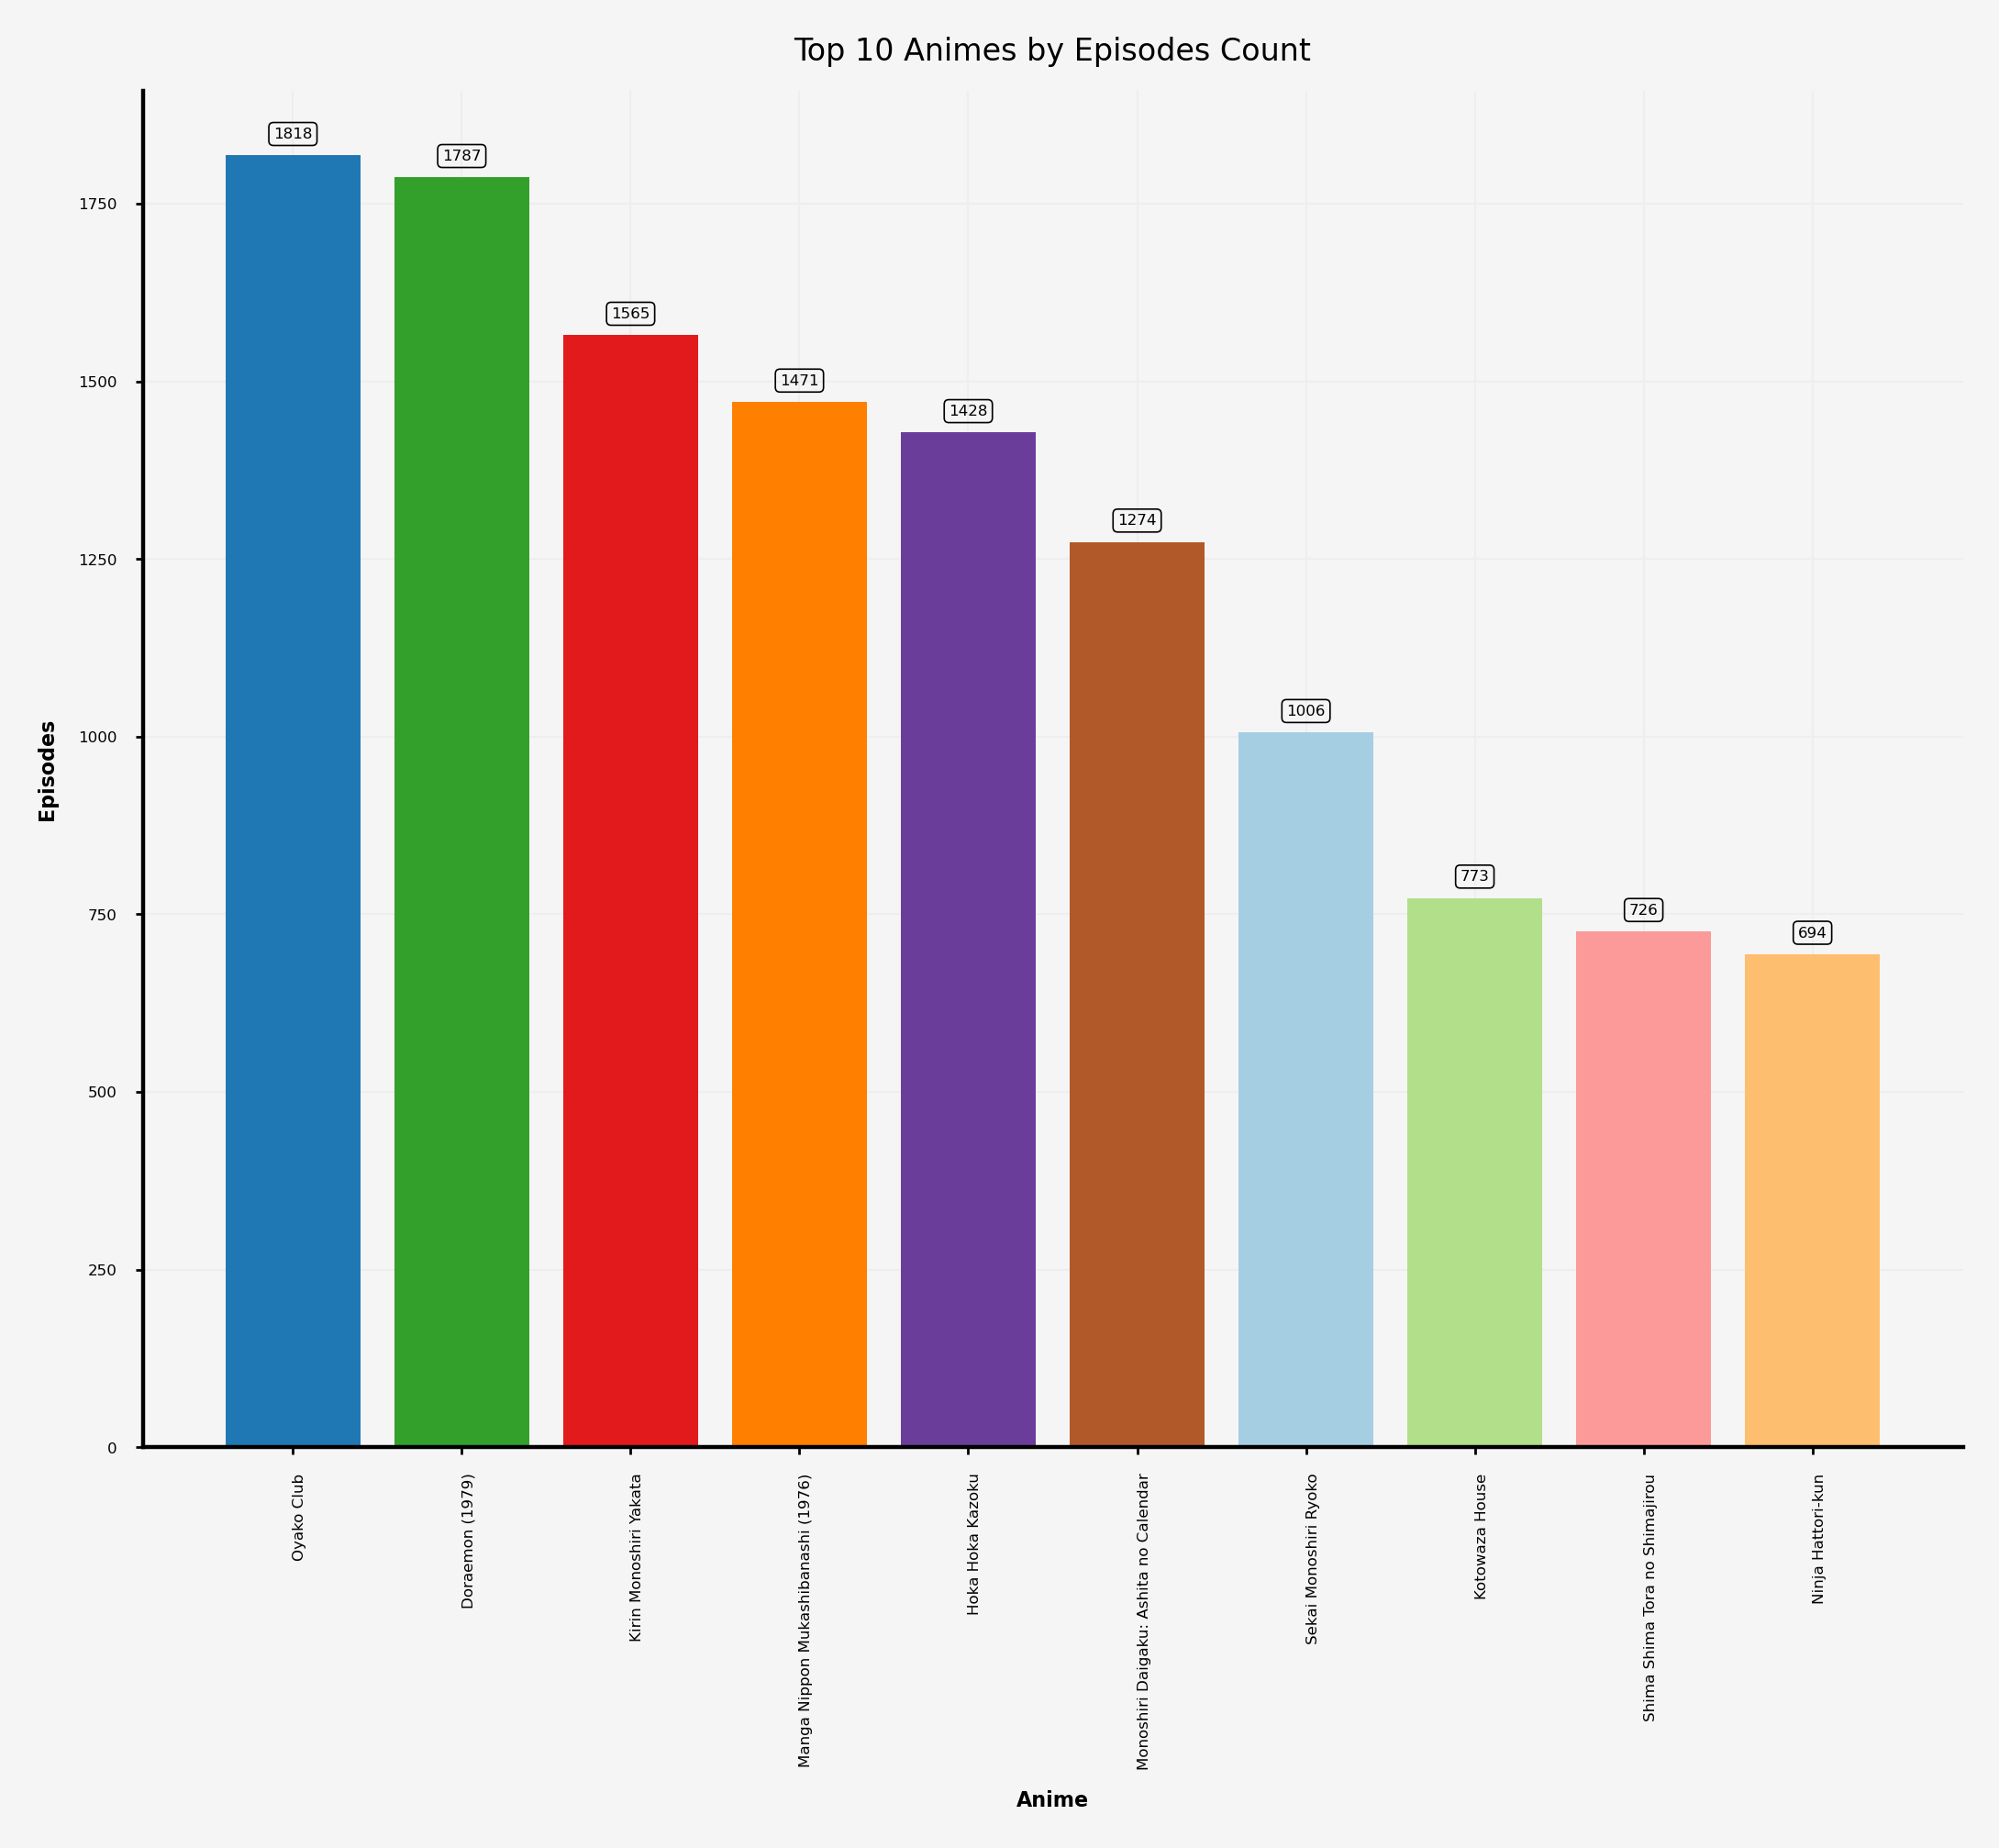

In [41]:
fig=plt.figure()
gs= fig.add_gridspec(1,wspace=0, hspace=0.05)
ax0= fig.add_subplot(gs[0,0])
ax0_plt= ax0.bar(x=episode_df["name"], height= episode_df["episodes"], zorder=2,  color=chart_colors)
plt.title("Top 10 Animes by Episodes Count", fontsize=6)
ax0.set_xticklabels(episode_df["name"], rotation=90,ha="right", rotation_mode="anchor")
ax0.set_xlabel('Anime',fontsize=4, weight='bold',)
ax0.set_ylabel('Episodes',fontsize=4, weight='bold')
ax0.grid(which='major', zorder=0, axis='x')
ax0.grid(which='major', zorder=0, axis='y')
for p in ax0_plt.patches:
    height= p.get_height()
    width= p.get_width()
    if height == 0:
        pass
    else:
        #find x and y coordinate of ear bar to add labels
        x= p.get_center()[0]
        y= height + 30
        label_value= f'{height:.0f}' 
        ax0.text(x,y,label_value, ha='center', va="center", bbox= dict(boxstyle='round'))
plt.show()

In [42]:
episode_rating_df= anime_df.groupby(["anime_id","name","rating"])["episodes"].unique().apply(lambda x:x[0]).reset_index().sort_values("episodes",ascending=False).head(10)
episode_rating_df

,anime_id,name,rating,episodes
6735,12393,Oyako Club,6.18,1818.0
2261,2471,Doraemon (1979),7.76,1787.0
8887,23349,Kirin Monoshiri Yakata,5.56,1565.0
4530,6277,Manga Nippon Mukashibanashi (1976),6.48,1471.0
5275,8213,Hoka Hoka Kazoku,6.05,1428.0
8608,22221,Monoshiri Daigaku: Ashita no Calendar,6.80,1274.0
6116,10241,Sekai Monoshiri Ryoko,5.92,1006.0
8216,20117,Kotowaza House,5.63,773.0
5884,9768,Shima Shima Tora no Shimajirou,6.25,726.0
3885,4936,Ninja Hattori-kun,6.92,694.0


## Popularity Filtering

In [43]:
df[df["rating_counts"].ge(500)].sort_values("user_rating", ascending=False)

,anime_id,name,type,genre,episodes,rating,members,user_rating,rating_counts
8661,28977,Gintama°,TV,"Action, Comedy, Historical, Parody, Samurai, S...",51.0,9.25,114262.0,9.45,1188.0
9522,32281,Kimi no Na wa.,Movie,"Drama, Romance, School, Supernatural",1.0,9.37,200630.0,9.43,1961.0
739,820,Ginga Eiyuu Densetsu,OVA,"Drama, Military, Sci-Fi, Space",110.0,9.11,80679.0,9.39,803.0
3936,5114,Fullmetal Alchemist: Brotherhood,TV,"Action, Adventure, Drama, Fantasy, Magic, Mili...",64.0,9.26,793665.0,9.32,21494.0
5787,9969,Gintama&#039;,TV,"Action, Comedy, Historical, Parody, Samurai, S...",51.0,9.16,151266.0,9.27,3115.0
...,...,...,...,...,...,...,...,...,...
1485,1639,Boku no Pico,OVA,"Hentai, Yaoi",1.0,5.13,57355.0,5.35,1783.0
4514,6392,Issho ni Training: Training with Hinako,OVA,"Ecchi, Sports",1.0,4.92,11989.0,5.16,529.0
714,788,Eiken: Eikenbu yori Ai wo Komete,OVA,"Comedy, Ecchi, Harem, School",2.0,4.65,15764.0,5.07,753.0
7484,19315,Pupa,TV,"Fantasy, Horror, Psychological",12.0,3.82,83652.0,4.22,2135.0


In [44]:
print("Top 10 anime by user_rating:")
Popluarity_df= df[df["rating_counts"].ge(1000)].sort_values("user_rating", ascending=False)[["name","rating","user_rating","rating_counts"]].head(10)
Popluarity_df

Top 10 anime by user_rating:


,name,rating,user_rating,rating_counts
8661,Gintama°,9.25,9.45,1188.0
9522,Kimi no Na wa.,9.37,9.43,1961.0
3936,Fullmetal Alchemist: Brotherhood,9.26,9.32,21494.0
5787,Gintama&#039;,9.16,9.27,3115.0
5517,Steins;Gate,9.17,9.26,17151.0
831,Gintama,9.04,9.24,4264.0
6201,Hunter x Hunter (2011),9.13,9.23,7477.0
6892,Gintama&#039;: Enchousen,9.11,9.20,2126.0
6883,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,9.10,9.19,2147.0
9702,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,9.15,9.17,1038.0


In [45]:
# fig=plt.figure()
# gs= fig.add_gridspec(1,wspace=0, hspace=0.05)
# ax0= fig.add_subplot(gs[0,0])
# toplot=['rating','user_rating']
# x_value= np.arange(len(Popluarity_df["name"]))
# width=0.35
# ax0_plt= ax0.bar(x=x_value - width/2, height= Popluarity_df["rating"], zorder=2, width= width, color=chart_colors[-4], label="myanimelist.com")
# ax01_plt=ax0.bar(x=x_value + width/1.8, height= Popluarity_df["user_rating"], zorder=2, width= width, color=chart_colors[-3], label="user_rating")
# plt.title("How does Rating of top 10 rated anime by user differ from myanimelist.com rating?")
# ax0.set_xticks(x_value)
# ax0.set_xticklabels(Popluarity_df["name"], rotation=90,ha="right", rotation_mode="anchor")
# ax0.set_xlabel('Anime',fontsize=4, weight='bold',)
# ax0.set_ylabel('Rating',fontsize=4, weight='bold')
# ax0.grid(which='major', zorder=0, axis='x')
# ax0.grid(which='major', zorder=0, axis='y')
# for p,q in zip(ax0_plt.patches, ax01_plt.patches):
#     height_p= p.get_height()
#     width_p= p.get_width()
#     height_q= q.get_height()
#     width_q= q.get_width()
#     if height_p == 0:
#         pass
#     else:
#         #find x and y coordinate of ear bar to add labels
#         x= p.get_center()[0]
#         y= height_p + 0.2
#         label_value_p= str(height_p)
#         ax0.text(x, y, label_value_p, ha='center', va="center", bbox= dict(boxstyle='round'))
#     if height_q ==0:
#         pass
#     else:
#         x_q= q.get_center()[0]
#         y_q= height_q + 0.2
#         label_value_q= str(height_q)
#         ax0.text(x_q, y_q, label_value_q, ha='center', va="center", bbox= dict(boxstyle='round'))

# ax0.legend(title="Rating by:",ncols=2, borderpad=0.8,markerscale=0.5, labelspacing=1, bbox_to_anchor=(1, 1.01), loc='lower right' )
# plt.show()

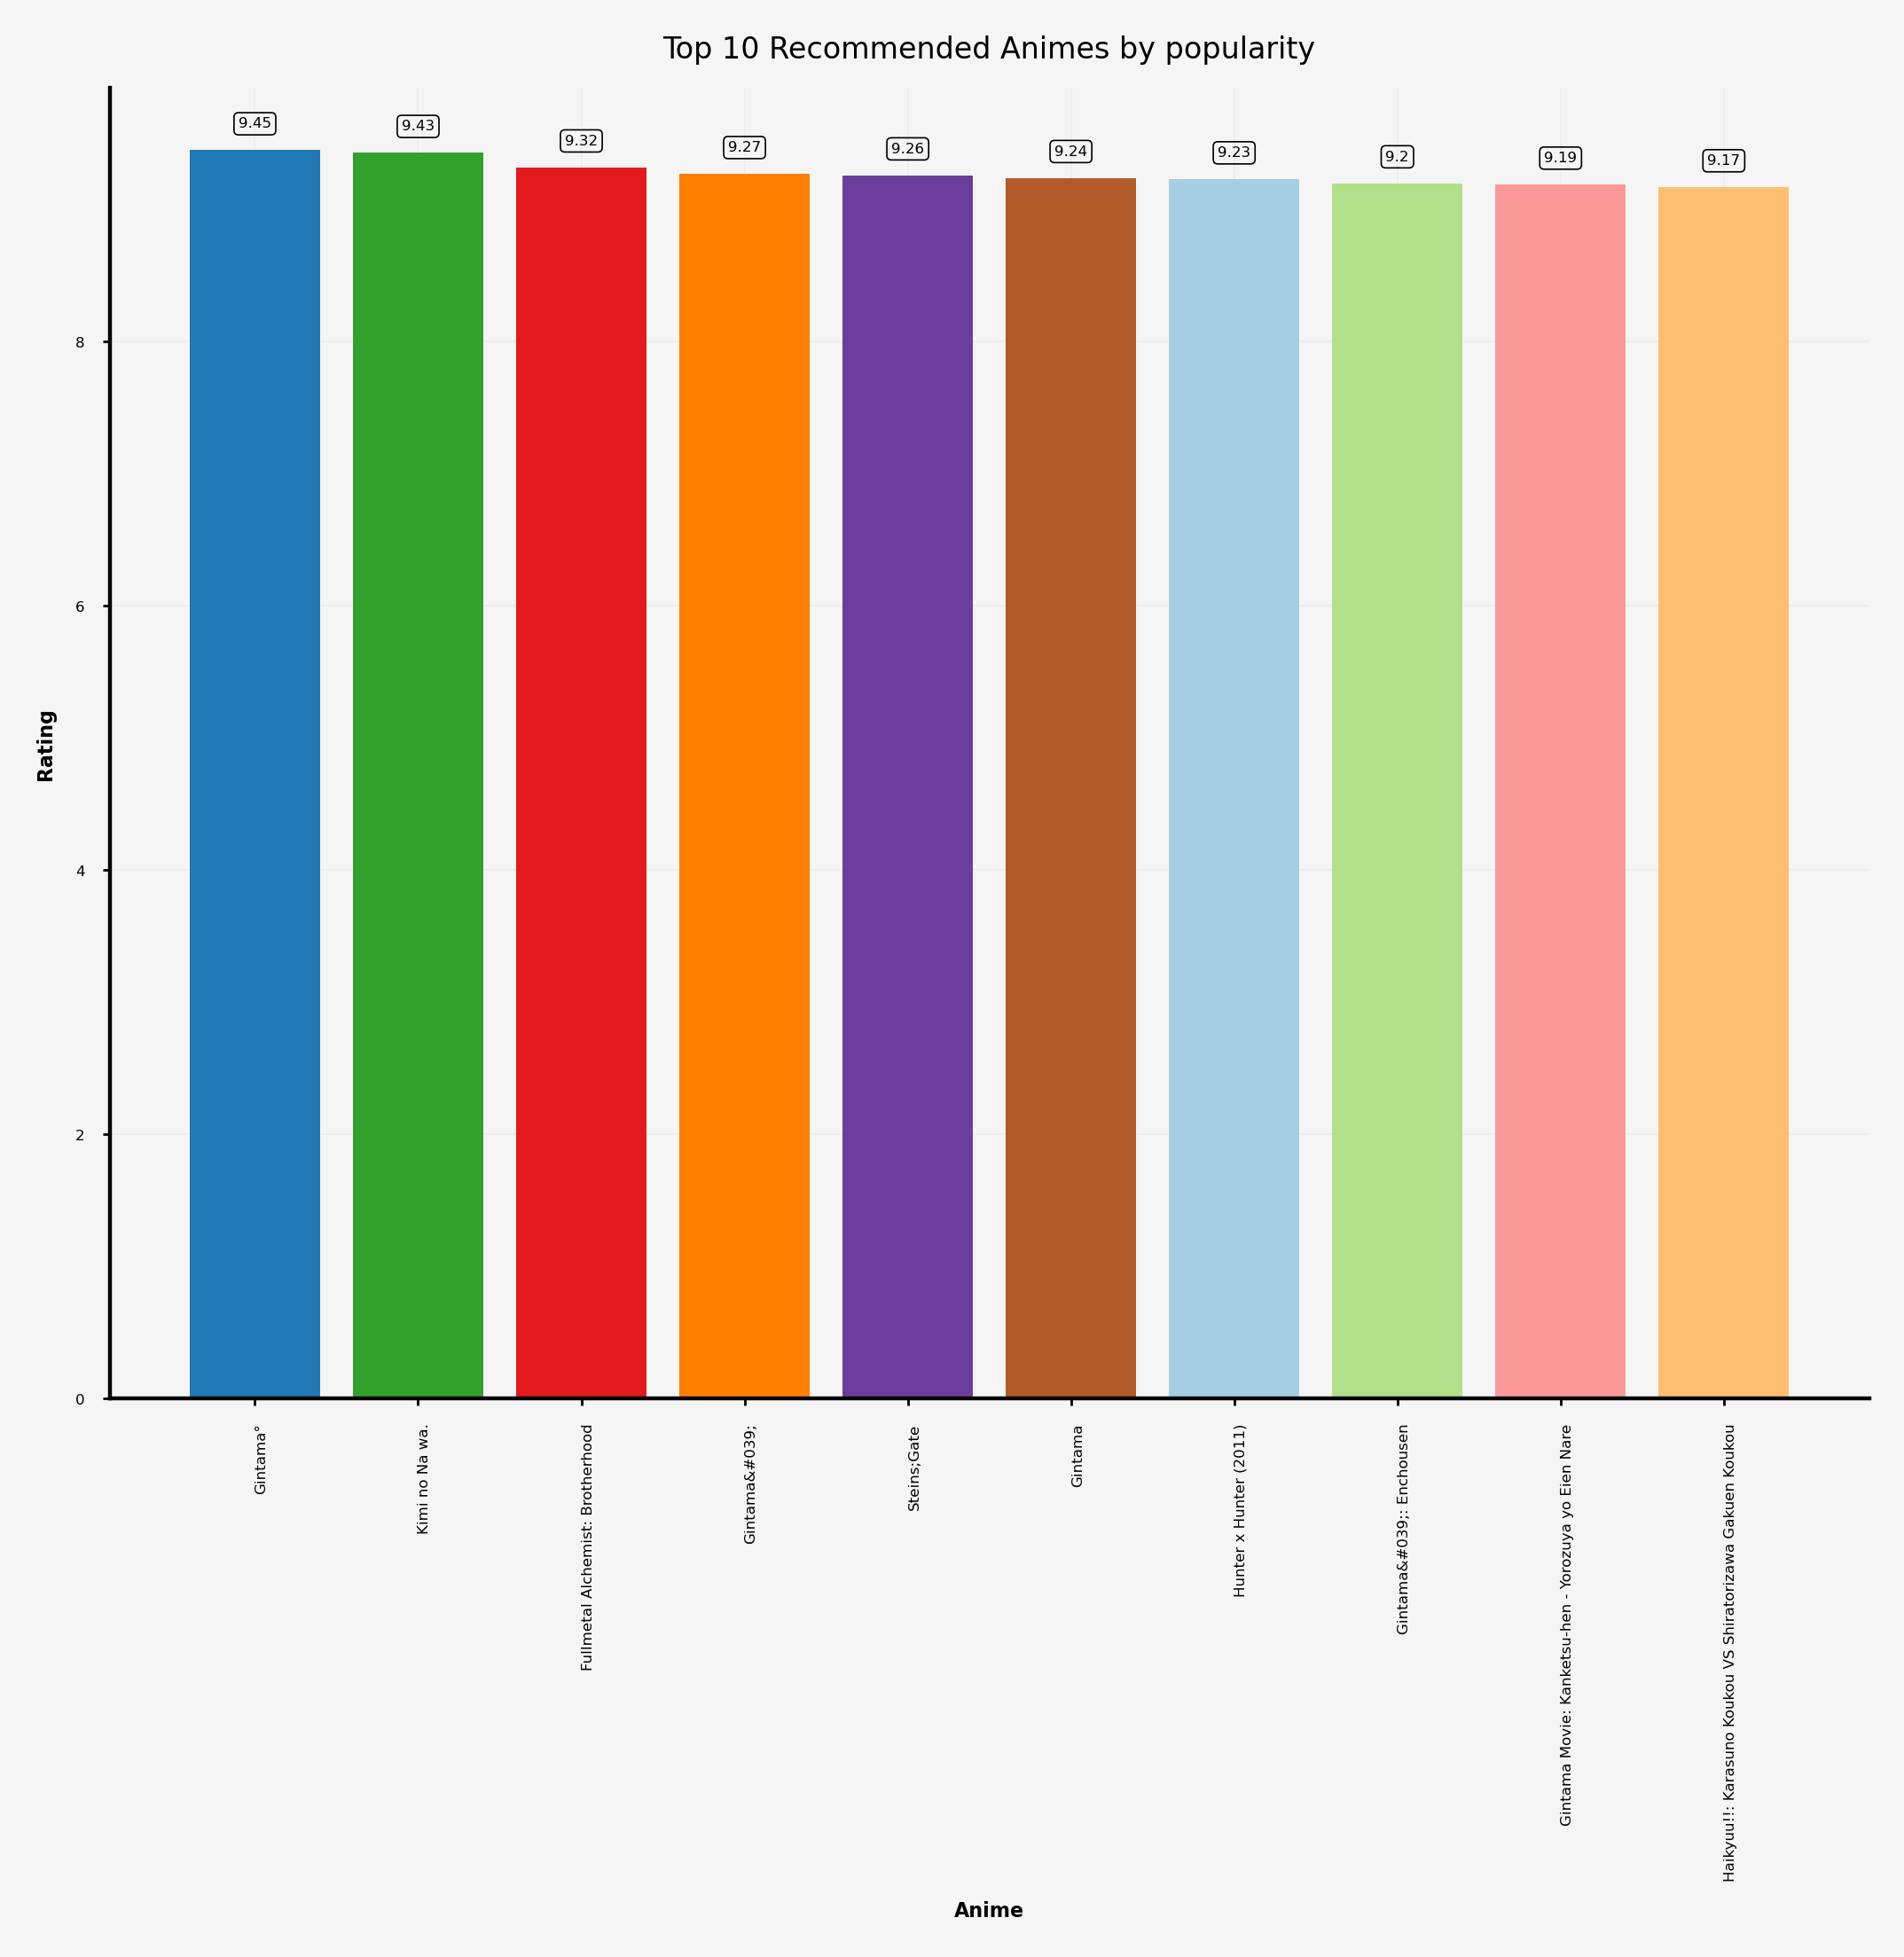

In [46]:
fig=plt.figure()
gs= fig.add_gridspec(1,wspace=0, hspace=0.05)
ax0= fig.add_subplot(gs[0,0])
toplot=['rating','user_rating']
x_value= np.arange(len(Popluarity_df["name"]))

ax0_plt= ax0.bar(x=x_value, height= Popluarity_df["user_rating"], zorder=2, color=chart_colors)
plt.title("Top 10 Recommended Animes by popularity", fontsize=6)
ax0.set_xticks(x_value)
ax0.set_xticklabels(Popluarity_df["name"], rotation=90,ha="right", rotation_mode="anchor")
ax0.set_xlabel('Anime',fontsize=4, weight='bold',)
ax0.set_ylabel('Rating',fontsize=4, weight='bold')
ax0.grid(which='major', zorder=0, axis='x')
ax0.grid(which='major', zorder=0, axis='y')
for p in ax0_plt.patches :
    height_p= p.get_height()
    width_p= p.get_width()
    if height_p == 0:
        pass
    else:
        #find x and y coordinate of ear bar to add labels
        x= p.get_center()[0]
        y= height_p + 0.2
        label_value_p= str(height_p)
        ax0.text(x, y, label_value_p, ha='center', va="center", bbox= dict(boxstyle='round'))
    
# ax0.legend(title="Rating by:",ncols=2, borderpad=0.8,markerscale=0.5, labelspacing=1, bbox_to_anchor=(1, 1.01), loc='lower right' )
plt.show()

## Collaborative Filtering

In [47]:
user_ratesgt100_bool=anime_df.groupby("user_id").count()["user_rating"] >100
user_ratesgt100=user_ratesgt100_bool[user_ratesgt100_bool].index
user_ratesgt100

Int64Index([    5,     7,    11,    14,    17,    21,    29,    38,    43,
               44,
            ...
            73494, 73495, 73499, 73500, 73502, 73503, 73504, 73507, 73510,
            73515],
           dtype='int64', name='user_id', length=19798)

In [48]:
user_ratesgt100_filt =anime_df[anime_df["user_id"].isin(user_ratesgt100)]
user_ratesgt100_filt.head()

,anime_id,name,genre,type,episodes,rating,members,user_id,user_rating,rating_counts
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,99,5.0,1961
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,152,10.0,1961
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,244,10.0,1961
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,271,10.0,1961
7,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,462,8.0,1961


In [49]:
anime_rates_count_gt1000_bool=anime_df.groupby("anime_id").count()["user_rating"] >1000
anime_rates_count_gt1000=anime_rates_count_gt1000_bool[anime_rates_count_gt1000_bool].index
anime_rates_count_gt1000

Int64Index([    1,     5,     6,     7,    15,    16,    18,    19,    20,
               22,
            ...
            32281, 32282, 32379, 32438, 32542, 32729, 32828, 32935, 32998,
            34240],
           dtype='int64', name='anime_id', length=1462)

In [50]:
anime_rates_count_gt1000_filt =anime_df[anime_df["user_id"].isin(anime_rates_count_gt1000)]
anime_rates_count_gt1000_filt.head()

,anime_id,name,genre,type,episodes,rating,members,user_id,user_rating,rating_counts
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,99,5.0,1961
5,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,322,10.0,1961
7,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,462,8.0,1961
9,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,548,10.0,1961
10,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,570,10.0,1961


In [51]:
anime_rates_count_gt1000_filt["anime_id"].unique().size

5893

In [52]:
pivoted_data= anime_rates_count_gt1000_filt.pivot_table(index="name", columns="user_id", values="user_rating")
pivoted_data.fillna(0, inplace=True)

In [53]:
pivoted_data

user_id,1,5,7,15,16,18,19,20,22,24,...,32281,32282,32379,32438,32542,32729,32828,32935,32998,34240
name,,,,,,,,,,,,,,,,,,,,,
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
&quot;Bungaku Shoujo&quot; Memoire,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
&quot;Bungaku Shoujo&quot; Movie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//G.U. Returner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//G.U. Trilogy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
xxxHOLiC,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
xxxHOLiC Kei,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
xxxHOLiC Movie: Manatsu no Yoru no Yume,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
from sklearn.metrics.pairwise import cosine_similarity

In [55]:
similarity_scores= cosine_similarity(pivoted_data)

In [56]:
similarity_scores

array([[1.        , 0.9469808 , 0.7438071 , ..., 0.19895045, 0.29481359,
        0.28661308],
       [0.9469808 , 1.        , 0.79563155, ..., 0.17184323, 0.26734386,
        0.2657647 ],
       [0.7438071 , 0.79563155, 1.        , ..., 0.11705585, 0.19164465,
        0.20177413],
       ...,
       [0.19895045, 0.17184323, 0.11705585, ..., 1.        , 0.58869762,
        0.66186066],
       [0.29481359, 0.26734386, 0.19164465, ..., 0.58869762, 1.        ,
        0.76776876],
       [0.28661308, 0.2657647 , 0.20177413, ..., 0.66186066, 0.76776876,
        1.        ]])

In [58]:
def recommend(anime_name):
    index= np.where(pivoted_data.index==anime_name)[0][0]
    similer_items= sorted(list(enumerate(similarity_scores[index])),key= lambda x:x[1],reverse=True)[1:6]
    for i in similer_items:
        print(pivoted_data.index[i[0]])

In [60]:
recommend("Doraemon (1979)")

Ace wo Nerae!
Kiteretsu Daihyakka
Miracle Giants Doumu-kun
Ninja Hattori-kun
Robin Hood no Daibouken


In [59]:
import seaborn as sns
import matplotlib

In [60]:
fig= plt.figure()
gs= fig.add_gridspec(1)
gs.update(wspace=0, hspace=0.05)
ax0= fig.add_subplot(gs[0,0])
ax0_plt=sns.swarmplot(x="type",  y="user_rating", hue="type", data= anime_df, s=0.5, zorder=4 , palette= exclude_colors[:6])
ax0_viol=sns.violinplot(x="type", y="user_rating", data= anime_df,ax=ax0 , palette= exclude_colors)

for collection in ax0_viol.collections:
    if isinstance(collection, matplotlib.collections.PolyCollection):
        collection.set_edgecolor(collection.get_facecolor())
        collection.set_facecolor('none')
        collection.set_linewidth(0.5)
        collection.set_zorder(2)

plt.title("Distribution of rating by Anime Type (myanimelist.com)")
ax0.set_xlabel('Anime Type',fontsize=4, weight='bold',)
ax0.set_ylabel('Rating',fontsize=4, weight='bold')
ax0.grid(which='major', zorder=0, axis='x')
ax0.grid(which='major', zorder=0, axis='y')
ax0_plt.legend(title="Anime Type",ncols=2, borderpad=0.8,markerscale=0.5, labelspacing=1 )
plt.show()

In [ ]:
# fig= plt.figure()
# gs= fig.add_gridspec(1)
# gs.update(wspace=0, hspace=0.05)
# ax0= fig.add_subplot(gs[0,0])
# ax0_plt=user_rating_ge0.plot('rating', "user_rating" ,zorder=2,kind='scatter', color='black' ,ax= ax0, s=0.5)

In [ ]:
for p in ax0_plt.patches:
    print("patches:",p)
    print("get_angle:", p.get_angle())
    print("get_bbox() :",p.get_bbox())
    print("get_center:", p.get_center(),"\n")
    print("get_corners:", p.get_corners())#corner on anticlockwise direction
    print("get_height:", p.get_height())
    print("get_path:", p.get_path())
    print("get_width:", p.get_width())
    print("get_xy:", p.get_xy())
    print("get_x() :", p.get_x())
    print("get_y() :",p.get_y())
    print("rotation_point :",p.rotation_point)
    print("get_facecolor() :",p.get_facecolor())
    print('---'*20)

patches: Rectangle(xy=(-0.25, 0), width=0.5, height=1818, angle=0)
get_angle: 0.0
get_bbox() : Bbox(x0=-0.25, y0=0.0, x1=0.25, y1=1818.0)
get_center: [  0. 909.] 

get_corners: [[-2.500e-01  0.000e+00]
 [ 2.500e-01  0.000e+00]
 [ 2.500e-01  1.818e+03]
 [-2.500e-01  1.818e+03]]
get_height: 1818.0
get_path: Path(array([[0., 0.],
       [1., 0.],
       [1., 1.],
       [0., 1.],
       [0., 0.]]), array([ 1,  2,  2,  2, 79], dtype=uint8))
get_width: 0.5
get_xy: (-0.25, 0)
get_x() : -0.25
get_y() : 0
rotation_point : xy
get_facecolor() : (0.12156862745098039, 0.47058823529411764, 0.7058823529411765, 1.0)
------------------------------------------------------------
patches: Rectangle(xy=(0.75, 0), width=0.5, height=1787, angle=0)
get_angle: 0.0
get_bbox() : Bbox(x0=0.75, y0=0.0, x1=1.25, y1=1787.0)
get_center: [  1.  893.5] 

get_corners: [[7.500e-01 0.000e+00]
 [1.250e+00 0.000e+00]
 [1.250e+00 1.787e+03]
 [7.500e-01 1.787e+03]]
get_height: 1787.0
get_path: Path(array([[0., 0.],
       [1